# **Exploratory data analysis and traditional ML models**

This notebook has implements some basic methods to help explore our dataset in order to better know the features which will help in increasing classification accuracy. Since the dataset is well balanced, accuracy is used as an evaluation metric.

In [1]:
import numpy as np
import pandas as pd
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from nltk.tokenize import word_tokenize 
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
DATA_PATH = '/content/drive/My Drive/Reddit_dataset/dataset_final.csv'

In [3]:
# Load and shuffle the dataset

dataset = pd.read_csv(DATA_PATH)
dataset = dataset.sample(frac=1.).reset_index(drop=True)
dataset.head()

,Unnamed: 0,created_utc,url,num_comments,selftext,title,over_18,link_flair_text,id,permalink
0,19525,1569559139,https://media.biltrax.com/shamuka-beach-projec...,0,NaN,Government of Odisha to develop the Shamuka Be...,False,Policy/Economy,d9vfbq,/r/india/comments/d9vfbq/government_of_odisha_...
1,11,1584193837,https://www.businesstoday.in/sectors/banks/ban...,25,NaN,Nirmala humiliated SBI Chairman: Bank officers...,False,Politics,fiin4y,/r/india/comments/fiin4y/nirmala_humiliated_sb...
2,3980,1581262524,https://theprint.in/opinion/pov/talking-to-cab...,19,NaN,Talking to cab drivers about politics is the o...,False,Politics,f1a6p2,/r/india/comments/f1a6p2/talking_to_cab_driver...
3,7078,1585890513,https://bossnews360.com/2020/04/03/modi-said-i...,0,NaN,"Modi said - In the fight against Corona, this ...",False,Coronavirus,fu28pc,/r/india/comments/fu28pc/modi_said_in_the_figh...
4,33280,1553087572,https://gadgets.ndtv.com/laptops/news/imac-pro...,5,NaN,iMac Pro Is Now Available With Up to 256GB of RAM,False,Science/Technology,b3bumd,/r/india/comments/b3bumd/imac_pro_is_now_avail...


Displaying the distribution of classes in the dataset. As seen here, the dataset is balanced.

In [0]:
def print_classes(data):
  flairs = list(set(data['link_flair_text']))
  for flair in flairs:
    print("Class " + flair + ": " + str(len(data[data['link_flair_text'] == flair])))

In [5]:
print_classes(dataset)

Class AskIndia: 6000
Class Coronavirus: 6000
Class Science/Technology: 6000
Class Politics: 6000
Class Non-Political: 6000
Class Policy/Economy: 6000


In [0]:
def print_bar_graph(data):
  cnt = data['link_flair_text'].value_counts()
  plt.figure(figsize=(14,8))
  sns.barplot(cnt.index, cnt.values)
  plt.ylabel('Number of Occurrences', fontsize=12)
  plt.xlabel('Flair', fontsize=12)
  plt.show()

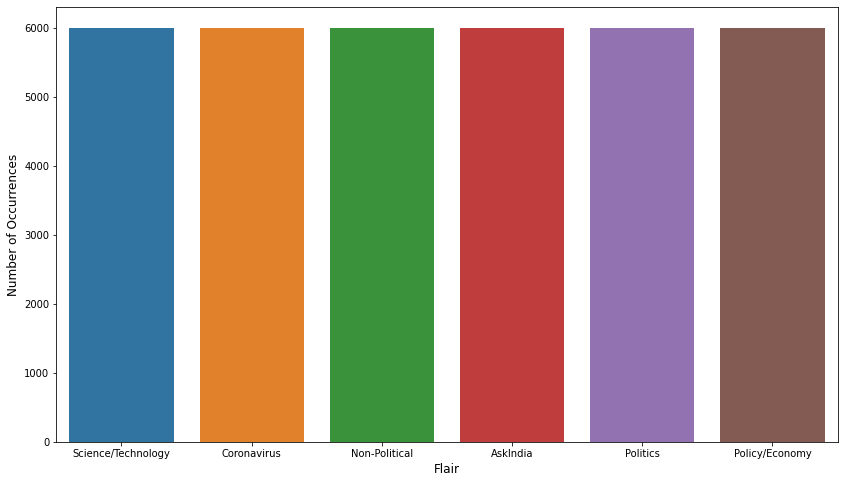

In [0]:
print_bar_graph(dataset)

#### **Evaluation fo invalids in the dataset**

Every post in the dataset has a title. However, the same cannot be said about the body/selftext of the post. Hence, we try to find the total number of posts which had their body deleted, removed or had no body to begin with.

In [0]:
invalid_inputs = ['[deleted]', 'nan', '[removed]']
flairs = list(set(dataset['link_flair_text']))

dataset['title'] = dataset['title'].astype(str)
dataset['selftext'] = dataset['selftext'].astype(str)

In [0]:
def get_invalid_inputs(data, flairs):
  invalid_dict = {'posts': [], 'flair': [], 'number': []}
  for flair in flairs:
    invalid_dict['flair'].append(flair)
    invalid_dict['posts'].append('total')
    invalid_dict['number'].append(len(data[data['link_flair_text'] == flair]))
    for invalid_input in invalid_inputs:
      invalid_dict['flair'].append(flair)
      invalid_dict['posts'].append(invalid_input)
      invalid_dict['number'].append(len(data[(data['selftext'] == invalid_input) & (data['link_flair_text'] == flair)]))
  data_df = pd.DataFrame.from_dict(invalid_dict)
  return data_df

In [0]:
invalid_df = get_invalid_inputs(dataset, flairs)

As evident from the bargraph below, majority of posts do not have a text body. As a result I replace the invalid text body with an empty string.

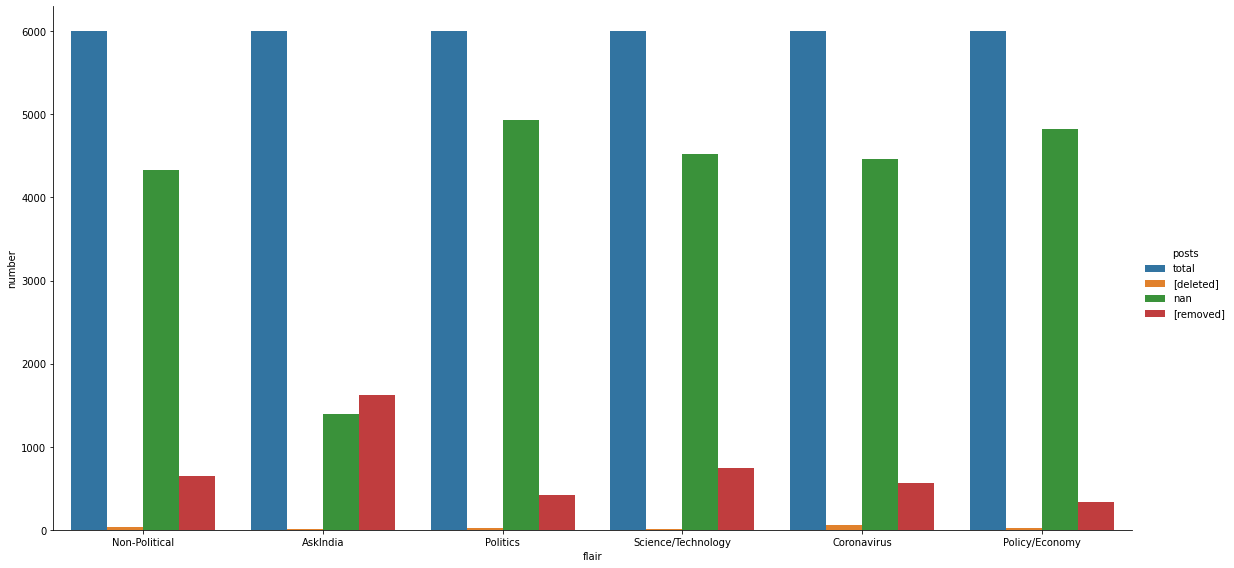

In [0]:
sns.catplot(x='flair', y='number', hue='posts', data=invalid_df, kind='bar', height=8, aspect=2)

In [0]:
dataset['selftext'] = dataset['selftext'].apply(lambda val: '' if val in invalid_inputs else val)

Verifying that the dataset no longer contains any posts with invalid body texts.

In [9]:
for invalid_input in invalid_inputs:
  print(invalid_input, len(dataset[dataset['selftext'] == invalid_input]))

[deleted] 0
nan 0
[removed] 0


In [0]:
dataset['title'] = dataset['title'] + ' ' + dataset['selftext']

In [11]:
stop = stopwords.words('english')
print(flairs)
data_flairs = {}
for flair in flairs:
  data_flairs[flair] = list(dataset[dataset['link_flair_text'] == flair]['title'])

['AskIndia', 'Coronavirus', 'Science/Technology', 'Politics', 'Non-Political', 'Policy/Economy']


#### **Visualize the work tokens in each flair**

In order to visualize the impact and usage of words in each flair, I used a word cloud. Words are given more prominence if they occue multiple times in the vocabulary in the dataset. One result which is evident is that there are quite a few common words between posts in different flairs such as 'India' and 'Indian'.

AskIndia


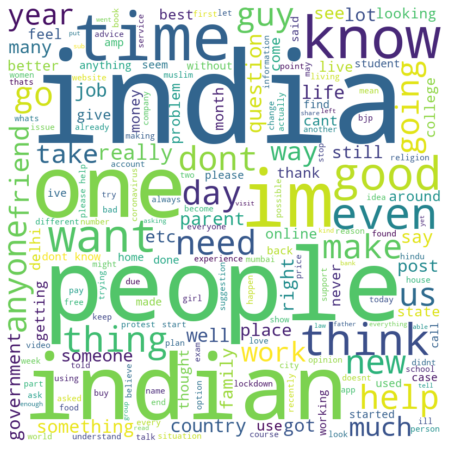

Coronavirus


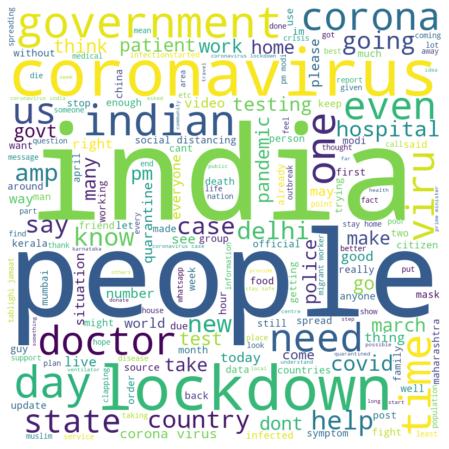

Science/Technology


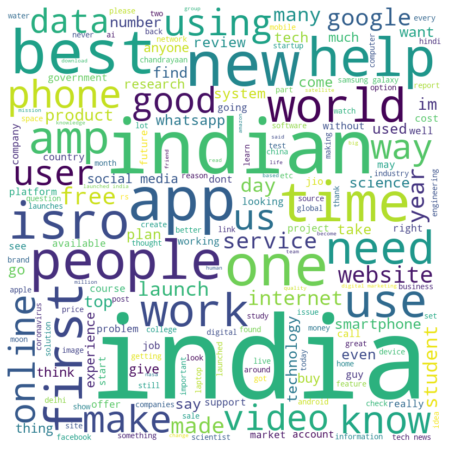

Politics


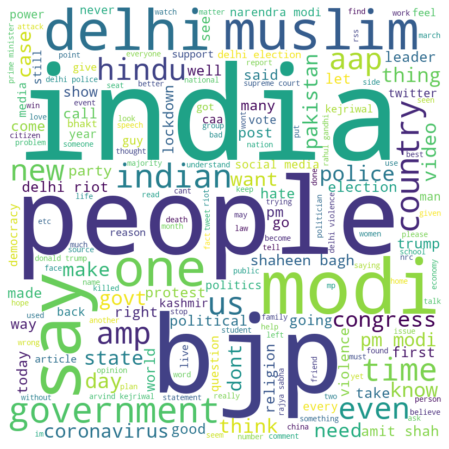

Non-Political


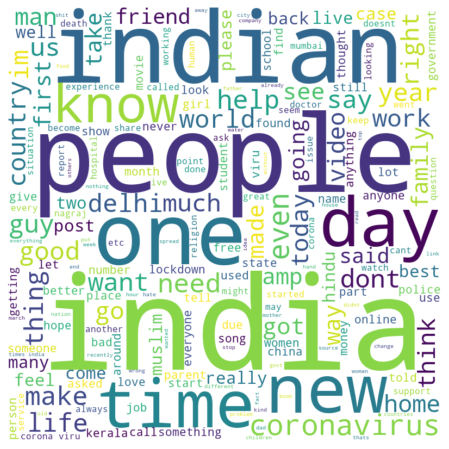

Policy/Economy


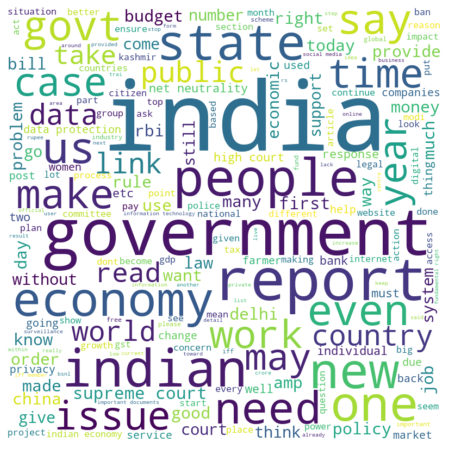

In [15]:
def generate_word_tokens(values):
  token_list = []
  for value in values:
    value = re.sub('http[s]?://\S+', '', value)
    value = value.translate(str.maketrans('', '', punctuation))
    value = value.lower().strip()
    token_list.extend([i for i in word_tokenize(value.lower()) if i not in stop and i.isalpha()])
  return token_list

def generate_word_cloud(word_dict):
  for keys, values in word_dict.items():
    token_list = generate_word_tokens(values)
    print(keys)
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(' '.join(token for token in token_list))
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_word_cloud(data_flairs)

Cleaning the text to remove URLs, punctuation, stopwords and ensuring uniform spacing.

In [0]:
def clean_text(text):
  text = re.sub('http[s]?://\S+', '', text)
  text = text.translate(str.maketrans('', '', punctuation))
  text = text.lower().strip()
  text = ' '.join([i if i not in stop and i.isalpha() else '' for i in text.lower().split()])
  text = re.sub(r"\s{2,}", " ", text)
  return text

dataset['title'] = dataset['title'].apply(clean_text)

In [17]:
dataset.head()

,Unnamed: 0,created_utc,url,num_comments,selftext,title,over_18,link_flair_text,id,permalink
0,19525,1569559139,https://media.biltrax.com/shamuka-beach-projec...,0,,government odisha develop shamuka beach area n...,False,Policy/Economy,d9vfbq,/r/india/comments/d9vfbq/government_of_odisha_...
1,11,1584193837,https://www.businesstoday.in/sectors/banks/ban...,25,,nirmala humiliated sbi chairman bank officers ...,False,Politics,fiin4y,/r/india/comments/fiin4y/nirmala_humiliated_sb...
2,3980,1581262524,https://theprint.in/opinion/pov/talking-to-cab...,19,,talking cab drivers politics oldest cliché ube...,False,Politics,f1a6p2,/r/india/comments/f1a6p2/talking_to_cab_driver...
3,7078,1585890513,https://bossnews360.com/2020/04/03/modi-said-i...,0,,modi said fight corona sunday april pm turn li...,False,Coronavirus,fu28pc,/r/india/comments/fu28pc/modi_said_in_the_figh...
4,33280,1553087572,https://gadgets.ndtv.com/laptops/news/imac-pro...,5,,imac pro available ram,False,Science/Technology,b3bumd,/r/india/comments/b3bumd/imac_pro_is_now_avail...


### **Training traditional ML models**

Training four models to understand the effect of applying traditional machine learning methods on the dataset. I used the following models:



1.   Logistic regression
2.   Support vector machine
3.   Multinomial Naive Bayes
4.   Stocastich gradient descent classifier

Each model was trained using a pipeline which consisted of applying Count Vectorization, followed by TFIDF transformation and then feeding the features into the model.

In the end each model's accuracy is printed in addition to a confusion matrix and the classification report.



In [0]:
def train_log_reg(X_train, y_train, X_test, y_test):
  logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=5000)),
               ])
  logreg = logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  predictions_train = logreg.predict(X_train[:5000])

  print("Training accuracy:", accuracy_score(predictions_train, y_train[:5000]))
  print("Accuracy:", accuracy_score(y_pred, y_test))

  conf_mat = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=flairs, yticklabels=flairs)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  print(classification_report(y_test, y_pred,target_names=flairs))
  filename = "logreg.pkl"  

  with open(filename, 'wb') as file:  
    pickle.dump(logreg, file)

In [0]:
def train_svc(X_train, y_train, X_test, y_test):
  svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC()),
               ])
  svc = svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  predictions_train = svc.predict(X_train[:5000])

  print("Training accuracy:", accuracy_score(predictions_train, y_train[:5000]))
  print("Accuracy:", accuracy_score(y_pred, y_test))

  conf_mat = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=flairs, yticklabels=flairs)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  print(classification_report(y_test, y_pred,target_names=flairs))

  filename = "svc.pkl"  

  with open(filename, 'wb') as file:  
    pickle.dump(svc, file)

In [0]:
def train_multinomial_naive_bayes(X_train, y_train, X_test, y_test):
  multi_nb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
               ])
  multi_nb.fit(X_train, y_train)
  y_pred = multi_nb.predict(X_test)
  predictions_train = multi_nb.predict(X_train[:5000])

  print("Training accuracy:", accuracy_score(predictions_train, y_train[:5000]))
  print("Accuracy:", accuracy_score(y_pred, y_test))

  conf_mat = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=flairs, yticklabels=flairs)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  print(classification_report(y_test, y_pred,target_names=flairs))
  filename = "multi_nb.pkl"  

  with open(filename, 'wb') as file:  
    pickle.dump(multi_nb, file)

In [0]:
def train_sgd_classifier(X_train, y_train, X_test, y_test):
  sgd_classifier = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
  sgd_classifier = sgd_classifier.fit(X_train, y_train)
  y_pred = sgd_classifier.predict(X_test)
  predictions_train = sdg_classifier.predict(X_train[:5000])

  print("Training accuracy:", accuracy_score(predictions_train, y_train[:5000]))
  print("Accuracy:", accuracy_score(y_pred, y_test))

  conf_mat = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=flairs, yticklabels=flairs)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  print(classification_report(y_test, y_pred,target_names=flairs))

  filename = "sgd_classifier.pkl"  

  with open(filename, 'wb') as file:  
    pickle.dump(sdg_classifier, file)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataset['title'], dataset['link_flair_text'], test_size=0.20)

Training accuracy: 0.7848
Accuracy: 0.5944444444444444


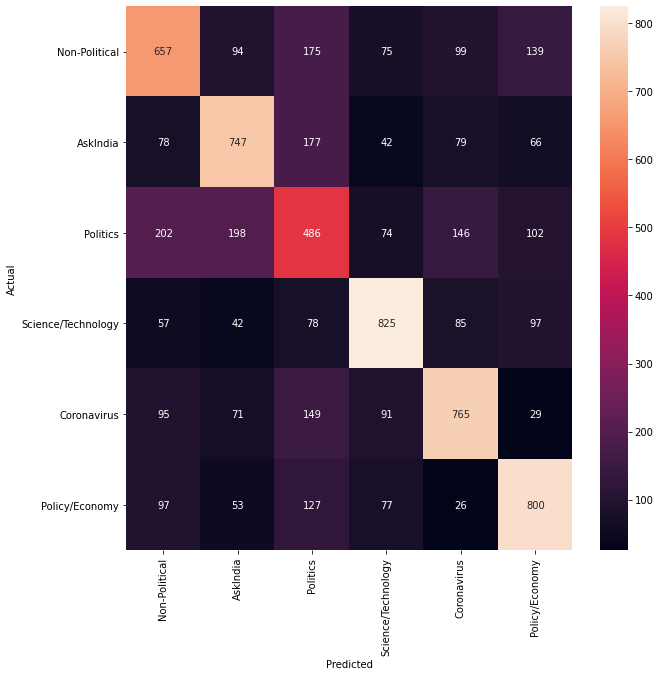

                    precision    recall  f1-score   support

     Non-Political       0.55      0.53      0.54      1239
          AskIndia       0.62      0.63      0.62      1189
          Politics       0.41      0.40      0.40      1208
Science/Technology       0.70      0.70      0.70      1184
       Coronavirus       0.64      0.64      0.64      1200
    Policy/Economy       0.65      0.68      0.66      1180

          accuracy                           0.59      7200
         macro avg       0.59      0.60      0.59      7200
      weighted avg       0.59      0.59      0.59      7200



In [0]:
train_log_reg(X_train, y_train, X_test, y_test)

Training accuracy: 0.9352
Accuracy: 0.5970833333333333


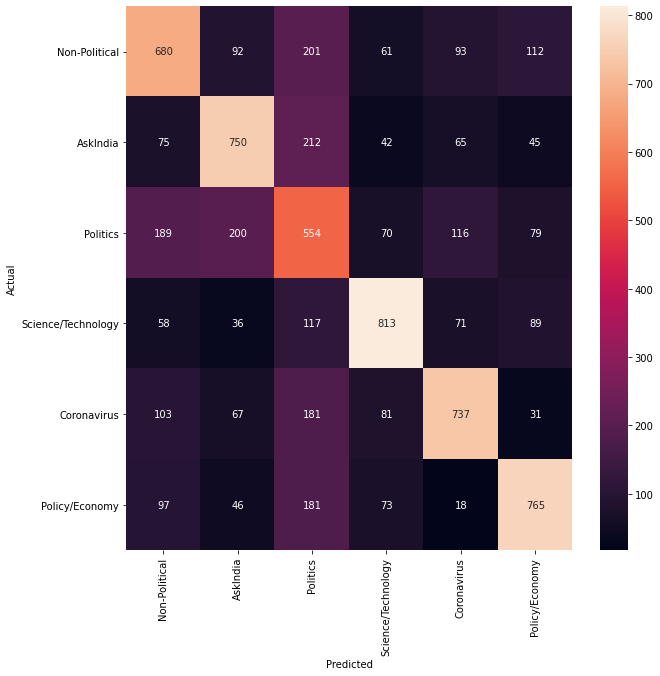

                    precision    recall  f1-score   support

     Non-Political       0.57      0.55      0.56      1239
          AskIndia       0.63      0.63      0.63      1189
          Politics       0.38      0.46      0.42      1208
Science/Technology       0.71      0.69      0.70      1184
       Coronavirus       0.67      0.61      0.64      1200
    Policy/Economy       0.68      0.65      0.66      1180

          accuracy                           0.60      7200
         macro avg       0.61      0.60      0.60      7200
      weighted avg       0.61      0.60      0.60      7200



In [0]:
train_svc(X_train, y_train, X_test, y_test)

Training accuracy: 0.7348
Accuracy: 0.5833333333333334


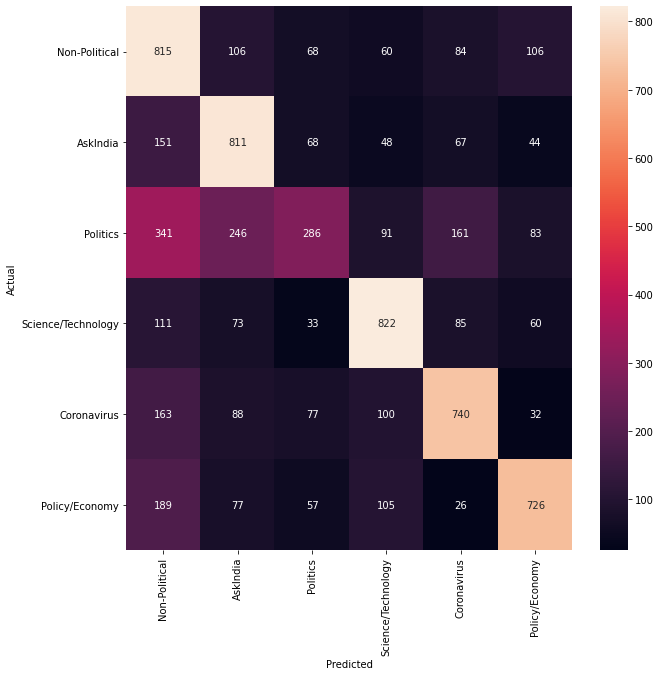

                    precision    recall  f1-score   support

     Non-Political       0.46      0.66      0.54      1239
          AskIndia       0.58      0.68      0.63      1189
          Politics       0.49      0.24      0.32      1208
Science/Technology       0.67      0.69      0.68      1184
       Coronavirus       0.64      0.62      0.63      1200
    Policy/Economy       0.69      0.62      0.65      1180

          accuracy                           0.58      7200
         macro avg       0.59      0.58      0.57      7200
      weighted avg       0.59      0.58      0.57      7200



In [0]:
train_multinomial_naive_bayes(X_train, y_train, X_test, y_test)

Training accuracy: 0.7306
Accuracy: 0.5758333333333333


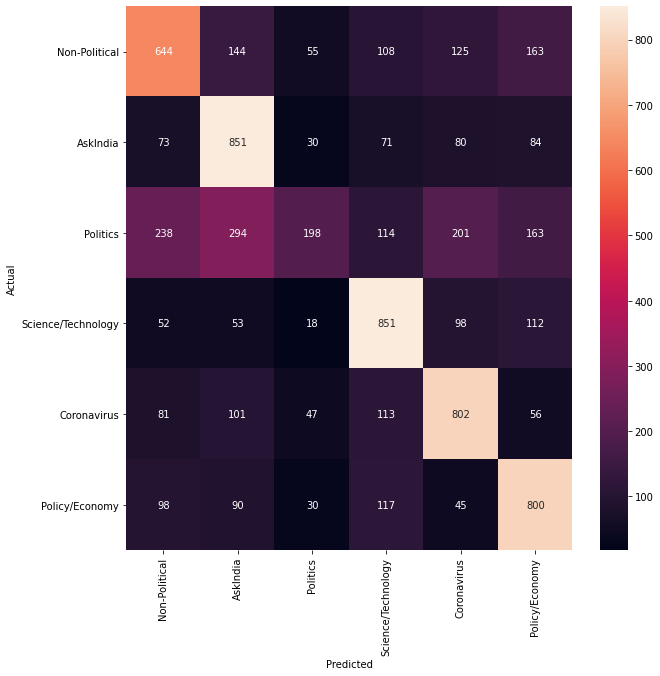

                    precision    recall  f1-score   support

     Non-Political       0.54      0.52      0.53      1239
          AskIndia       0.56      0.72      0.63      1189
          Politics       0.52      0.16      0.25      1208
Science/Technology       0.62      0.72      0.67      1184
       Coronavirus       0.59      0.67      0.63      1200
    Policy/Economy       0.58      0.68      0.63      1180

          accuracy                           0.58      7200
         macro avg       0.57      0.58      0.55      7200
      weighted avg       0.57      0.58      0.55      7200



In [0]:
train_sgd_classifier(X_train, y_train, X_test, y_test)

### **Inference**

As seen from the output of all 4 models, the SVM seems to have the highest accuracy of 0.597. However, it seems to be overfitting as the training accuracy is 0.935. As a result, I decided to go ahead with the logistic regression model with an accuracy of 0.594.

In [0]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LogisticRegression(max_iter=5000).fit(X_train_tfidf, y_train)

In [0]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_pred = clf.predict(X_test_tfidf)
predictions_train = clf.predict(X_train_tfidf[:5000])

print("Training accuracy:", accuracy_score(predictions_train, y_train[:5000]))
print("Accuracy:", accuracy_score(y_pred, y_test))

Training accuracy: 0.7848
Accuracy: 0.5944444444444444


Saving the model along with the scalers.

In [0]:
logreg = "/content/drive/My Drive/Reddit_dataset/Logreg/logreg.pkl"  
with open(logreg, 'wb') as file:  
  pickle.dump(clf, file)

count_scaler = "/content/drive/My Drive/Reddit_dataset/Logreg/count_scaler.pkl"
tdidf_scaler = "/content/drive/My Drive/Reddit_dataset/Logreg/tdidf_scaler.pkl"

with open(count_scaler, 'wb') as file:  
  pickle.dump(count_vect, file)

with open(tdidf_scaler, 'wb') as file:  
  pickle.dump(tfidf_transformer, file)